In [14]:
import os
import pandas as pd
import numpy as np 
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer    
from nltk.stem import WordNetLemmatizer
import timeit


#mnb imports
# Naive bayes with hyper parameter tuning
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

#cnn imports
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import sys
import pathlib

#tuning
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

sns.set()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
def getData(path):
    dataList = list()
    for subdir, dirs, files in os.walk(path):
        for file in files:
            #print(os.path.join(subdir, file))
            f = open(subdir+"/"+file, "r")
            dataList.append(f.read())
    return dataList
            
def avgWordCount(wordList):
    wordCount = 0
    for wordArray in wordList:
        wordCount += len(wordArray)
    wordAverage = wordCount/len(wordList)
    return wordAverage          


def preprocess(dataList, allPreprocessing = False):
    # https://textblob.readthedocs.io/en/dev/
    wordList = list()
    wordListStem = list()
    wordListLemmatized = list()
    
    # stemming / lemmatization
    # https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language='english')

    stops = set(stopwords.words("english"))
    for text in dataList:
            # lowercase
            textLowercase = text.lower()
            # remove digits (not sure if we should do this, ad does is in the slides)
            textFiltered = re.sub(r'\b[0-9]+\b\s*', '', textLowercase)
            #print(text)
            # get textblob
            blob = TextBlob(textFiltered)
            # tokenize
            words = blob.words
            #print(words)
            if (allPreprocessing):
                # remove stopwords and stem
                wordsFiltered_stem = [stemmer.stem(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered_lemmatized = [wordnet_lemmatizer.lemmatize(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                #print(wordsFiltered)
                wordList.append(wordsFiltered)
                wordListStem.append(wordsFiltered_stem)
                wordListLemmatized.append(wordsFiltered_lemmatized)
            else:
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                wordList.append(wordsFiltered)
                
    if (allPreprocessing):            
        return (wordList, wordListStem, wordListLemmatized)
    else:
        return wordList

"""
https://www.mygreatlearning.com/blog/bag-of-words/#ed4
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
Calculate bag of words representation 
datasets: array with test data in first slot and training data in second slot
ngram: corresponding ngram: (1,1) for unigrams, (2,2) for bigrams
classDist = class distribution of the datasets. default assumes no prior changes to the data structure
return: each return consists of 2 dataframes: first dataframe is test data, second data is train data. 
        bag_of_words_data holds features with absolute count; bag_of_words_data_freq has word frequencies
"""
def bagOfWords(datasets, ngram, classDist = [np.repeat([0,1], 80),np.repeat([0,1], 320)]):
    # hyperparameters: max features, use_idf                                             
    vectorizer = CountVectorizer(ngram_range=ngram)#, max_features=750)
    bag_of_words_data_freq = list()
    bag_of_words_data = list()                                         
    tf_transformer = TfidfTransformer()#use_idf=True)
    for idx, dataset in enumerate(datasets):
        # reconcatenate data to sentence which is needed for countvectorizer
        concatTexts = list()
        for text in dataset:
            concatTexts.append(' '.join(text))
        # create bag of words representation
        if(idx == 0):
            countData = vectorizer.fit_transform(concatTexts)
        else:
            countData = vectorizer.transform(concatTexts)

        cv_df=pd.DataFrame(countData.toarray(),columns=vectorizer.get_feature_names())
        cv_df['class_target']=classDist[idx]
        bag_of_words_data.append(cv_df)

        freqData = tf_transformer.fit_transform(countData)
        cv_df_freq=pd.DataFrame(freqData.toarray(),columns=vectorizer.get_feature_names())
        cv_df_freq['class_target']=classDist[idx]
        bag_of_words_data_freq.append(cv_df_freq)
    return (bag_of_words_data, bag_of_words_data_freq, vectorizer)


"""
Calculate metrics for a model and plot the confusion matrix
actual: array with actual classes
pred: array with predicted classes
return: confusion matrix and a tuple with 3 values of accuracy, precision and recall
"""
def getModelInfo(actual, pred):
    df_confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    acc = (df_confusion[1][1] + df_confusion[0][0]) / (df_confusion[0]["All"] + df_confusion[1]["All"])
    prec = (df_confusion[1][1] / df_confusion[1]["All"])
    recall = (df_confusion[1][1] / df_confusion["All"][1])
    f1 =  2*((prec*recall)/(prec+recall))
    metrics = (acc, prec, recall, f1)
    plot_confusion_matrix(df_confusion)
    print("Metrics: \n   Accuracy: %f \n   Precision: %f \n   Recall: %f \n   F1: %f" % metrics)
    return df_confusion, metrics
"""
Plot the confusion matrix as a heatmap
df_confusion: confusion matrix from a model
return: nothing
"""
def plot_confusion_matrix(df_confusion):
    sns.heatmap(df_confusion, annot=True, fmt="d")
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    return

def plotMetricsComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"], index=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    metrics_df.index.name = "Algorithm"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/" + title + '.png')
    plt.show()
    
    
    print(metrics_df)
    
def save_metrics(metrics_list, title="metrics"):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"])
    metrics_df = metrics_df.applymap(lambda x: round(x, 4))
    metrics_df.insert(loc=0, column='Algorithm', value=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    #metrics_df.insert(loc=0, column='Algorithm', value=[item for item in ["Multinomial naive Bayes","Logistic regression","Decision tree", "Random forest"] for i in range(3)])

    # round to 4 decimal places and save to csv file
    metrics_df.to_csv("tables/" + title + ".csv", sep = "&", index=False)

In [45]:
deceptive_test = getData(r"data\deceptive\test")
deceptive_train = getData(r"data\deceptive\train")
truthful_test = getData(r"data\truthful\test")
truthful_train = getData(r"data\truthful\train")
post_deceptive_test = preprocess(deceptive_test)
post_deceptive_train = preprocess(deceptive_train)
post_truthful_test = preprocess(truthful_test)
post_truthful_train = preprocess(truthful_train)

In [72]:
datasets = [post_deceptive_test + post_truthful_test, post_deceptive_train + post_truthful_train]
bag_of_words_data, bag_of_words_data_freq, vectorizer = bagOfWords(datasets = datasets, ngram = (1,1))
    
bag_of_words_test = bag_of_words_data[0]
bag_of_words_train = bag_of_words_data[1]
y_test = np.array(bag_of_words_test[['class_target']].values.ravel())
X_test = bag_of_words_test.drop('class_target', axis=1)
y_train = np.array(bag_of_words_train[['class_target']].values.ravel())
X_train = bag_of_words_train.drop('class_target', axis=1)


{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.0s finished


Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}


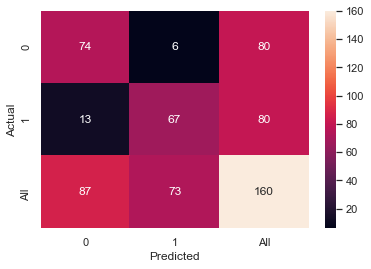

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817


In [47]:

metrics_list = list()
#for y_test, X_test, y_train, X_train in zip(y_test_list, X_test_list, y_train_list, X_train_list):
alpha = np.linspace(start = 0.0, stop = 10.0, num = 30)
fit_prior = [True, False]

# Create the random grid
random_grid = {'alpha': alpha,
               'fit_prior': fit_prior}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
mnb = MultinomialNB()
# Random search of parameters, using 3 fold cross validation, 
# search across 60 different combinations, and use all available cores
mnb_random = RandomizedSearchCV(estimator = mnb, param_distributions = random_grid, n_iter = 60, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='f1')

# Fit the random search model
mnb_random.fit(X_train, y_train)

# print the best parameters
print("Best parameters")
print(mnb_random.best_params_)

# The best model
mnb_best_random = mnb_random.best_estimator_

# Predict Class
mnb_random_y_pred = mnb_best_random.predict(X_test)

# Accuracy 
mnb_cm, mnb_metrics = getModelInfo(y_test, mnb_random_y_pred)
metrics_list.append(mnb_metrics)


Standard configuration 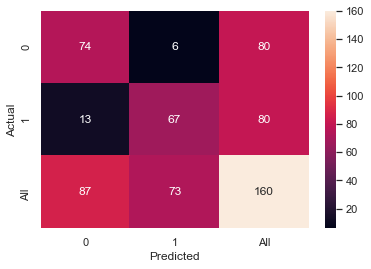
Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
   

Stemming cv=10 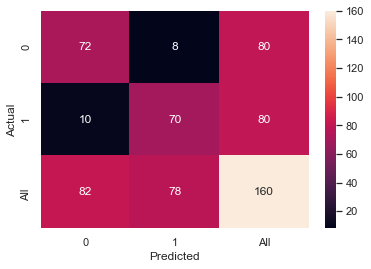
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
   
Lemmatization cv=10 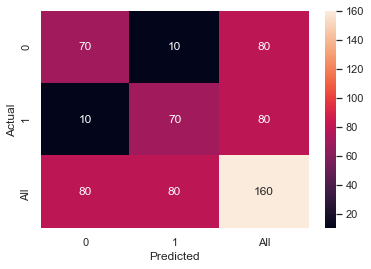
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000

Comparison of different preprocessing steps
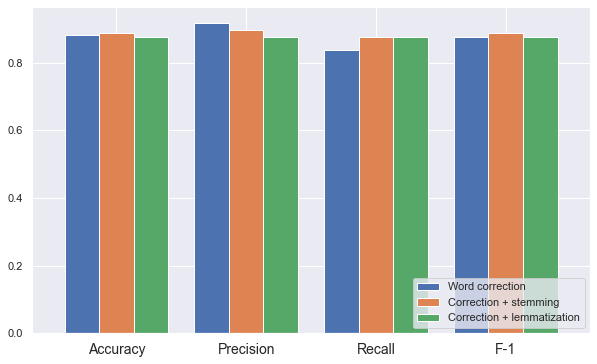

In [29]:
# functions used for CNN
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [30]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_train",
    batch_size=batch_size
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_test",
    batch_size=batch_size
)
print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)
# Model constants.
max_features = 20000
embedding_dim = 100
sequence_length = 300

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label
# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)
# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Found 640 files belonging to 2 classes.
Found 160 files belonging to 2 classes.
Number of batches in raw_train_ds: 20
Number of batches in raw_test_ds: 5


In [31]:
data_test = [(x, y) for x, y in test_ds] 
y_test_cnn = np.concatenate([y for (x, y) in data_test])
x_test_cnn = np.concatenate([x for (x, y) in data_test])

data_train = [(x, y) for x, y in train_ds] 
y_train_cnn = np.concatenate([y for (x, y) in data_train])
x_train_cnn = np.concatenate([x for (x, y) in data_train])

In [55]:
start = timeit.default_timer()
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
    model.add(layers.Embedding(max_features, embedding_dim))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(num_filters, kernel_size, padding="valid", activation="relu", strides=3))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

epochs = 20
embedding_dim = 100
maxlen = 500
param_grid = dict(num_filters=[32, 64, 128, 256],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=10, verbose=2, 
                          random_state = 42,
                          n_jobs = -1,
                          scoring='f1',                          
                          n_iter=5)
grid_result = grid.fit(x_train_cnn, y_train_cnn)

# Evaluate testing set
test_accuracy = grid.score(x_test_cnn, y_test_cnn)

stop = timeit.default_timer()
print('Time: ', stop - start)  
print(grid_result)
print(test_accuracy)
print(grid_result.best_params_)
print(grid_result.best_score_)
# print the best parameters
print("Best parameters")
print(grid_result.best_params_)

# The best model
best_random = grid_result.best_estimator_

# Predict Class
random_y_pred_cnn = np.concatenate(best_random.predict(x_test_cnn_g))
cnn_cm, cnn_metrics = getModelInfo(y_test_cnn_g, random_y_pred_cnn)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.6min finished


Time:  1399.2399966000012
RandomizedSearchCV(cv=10,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DE3BD138C8>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'embedding_dim': [100],
                                        'kernel_size': [3, 5, 7],
                                        'maxlen': [500],
                                        'num_filters': [32, 64, 128, 256],
                                        'vocab_size': [5000]},
                   random_state=42, scoring='f1', verbose=2)
0.8366013071895425
{'vocab_size': 5000, 'num_filters': 64, 'maxlen': 500, 'kernel_size': 7, 'embedding_dim': 100}
0.7910126946095957


In [26]:
# single run
model = keras.Sequential()
model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
model.add(layers.Embedding(max_features, embedding_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, 7, padding="valid", activation="relu", strides=3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


epochs = 50
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
# Fit the model using the train and test datasets.
history = model.fit(x_train, y_train,  
                    validation_split = 0.2,
                    callbacks=[es],
                    epochs=epochs)
# history = model.fit(x_train, y_train, 
#                     validation_data=(x_val, y_val), 
#                     epochs=epochs)

model.evaluate(test_ds)
plot_history(history)
data = [(x, y) for x, y in test_ds] 
y_test = np.concatenate([y for (x, y) in data])
x_test = np.concatenate([x for (x, y) in data])
y_pred_cnn = np.concatenate(model.predict_classes(x_test))
cnn_cm, cnn_metrics = getModelInfo(y_test, y_pred_cnn)

Epoch 1/150
16/16 [==============================] - 3s 208ms/step - loss: 0.7016 - accuracy: 0.4746 - val_loss: 0.6921 - val_accuracy: 0.4844
Epoch 2/150
16/16 [==============================] - 3s 207ms/step - loss: 0.6890 - accuracy: 0.5156 - val_loss: 0.6835 - val_accuracy: 0.7266
Epoch 3/150
16/16 [==============================] - 3s 209ms/step - loss: 0.6778 - accuracy: 0.5801 - val_loss: 0.6532 - val_accuracy: 0.7578
Epoch 4/150
16/16 [==============================] - 3s 210ms/step - loss: 0.5649 - accuracy: 0.8398 - val_loss: 0.5254 - val_accuracy: 0.7734
Epoch 5/150
16/16 [==============================] - 3s 205ms/step - loss: 0.3352 - accuracy: 0.9043 - val_loss: 0.4243 - val_accuracy: 0.7891
Epoch 6/150
16/16 [==============================] - 3s 207ms/step - loss: 0.1475 - accuracy: 0.9473 - val_loss: 0.4882 - val_accuracy: 0.7734
Epoch 7/150
16/16 [==============================] - 3s 207ms/step - loss: 0.0697 - accuracy: 0.9805 - val_loss: 0.5300 - val_accuracy: 0.7734

5/5 [==============================] - 0s 9ms/step - loss: 0.3945 - accuracy: 0.8875
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_83 (Embedding)     (None, None, 256)         5120000   
_________________________________________________________________
dropout_59 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, None, 128)         229504    
_________________________________________________________________
global_max_pooling1d_82 (Glo (None, 128)               0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 129       
=================================================================
Total params: 5,366,145
Trainable params: 5,366,145
Non-trainable params: 0
_________________________________________________________________
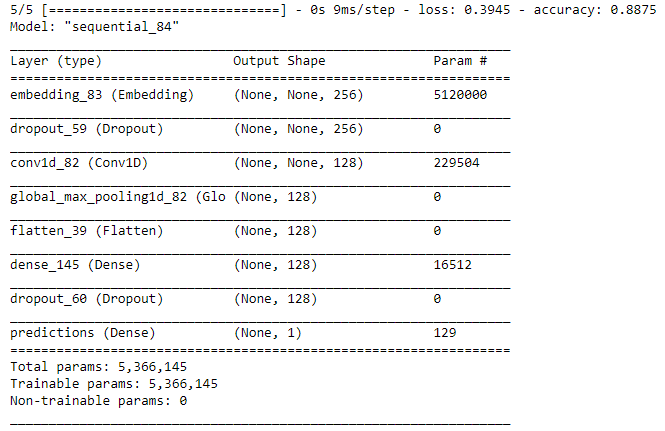
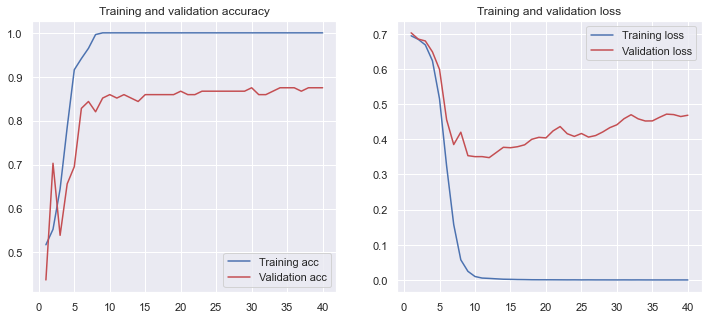
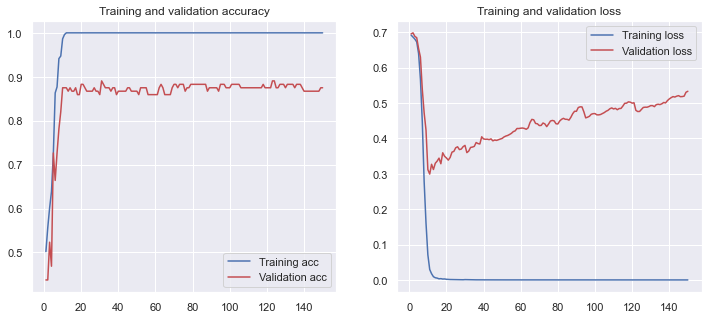

In [27]:
# Model constants.
max_features = 20000
embedding_dim = 100
sequence_length = 300
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
data_path = os.getcwd() + "/data/keras_train"
data_dir = pathlib.Path(data_path)
print(data_dir)
samples_train = []
labels_train = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples_train.append(content)
        labels_train.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples_train))


data_path_test = os.getcwd() + "/data/keras_test"
data_dir_test = pathlib.Path(data_path_test)
samples_test = []
labels_test = []
class_names_test = []
class_index = 0

for dirname in sorted(os.listdir(data_dir_test)):
    class_names_test.append(dirname)
    dirpath = data_dir_test / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples_test.append(content)
        labels_test.append(class_index)
    class_index += 1
vectorizer = TextVectorization(max_tokens=max_features, 
                               output_mode="int",
                               output_sequence_length=sequence_length)
text_ds = tf.data.Dataset.from_tensor_slices(samples_train).batch(128)
vectorizer.adapt(text_ds)
vectorizer.get_vocabulary()[:5]
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))



embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


x_train = vectorizer(np.array([[s] for s in samples_train])).numpy()
x_test_cnn_g = vectorizer(np.array([[s] for s in samples_test])).numpy()

y_train = np.array(labels_train)
y_test_cnn_g = np.array(labels_test)

Found 400000 word vectors.
C:\Users\quach\Dropbox\Uni\Faecher\Advanced Research Methods\Assignment\Code\data\keras_train
Processing deceptive, 320 files found
Processing truthful, 320 files found
Classes: ['deceptive', 'truthful']
Number of samples: 640
Processing deceptive, 80 files found
Processing truthful, 80 files found
Converted 4720 words (592 misses)


In [29]:
np.random.seed(420)
start = timeit.default_timer()
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
    model.add(layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    ))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(num_filters, kernel_size, padding="valid", activation="relu", strides=3))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

#epochs = [25, 50, 75, 100]
embedding_dim = 100
maxlen = 500
param_grid = dict(num_filters=[32, 64, 128, 256],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = KerasClassifier(build_fn=create_model,
                        epochs = 80,
                        batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=10, verbose=2, 
                          random_state = 42,
                          n_jobs = -1,
                          scoring='f1',                          
                          n_iter=5)
grid_result = grid.fit(x_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(x_test, y_test)

stop = timeit.default_timer()
print('Time: ', stop - start)  
print(grid_result)
print(test_accuracy)
print(grid_result.best_params_)
print(grid_result.best_score_)


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.1min finished


Time:  995.6763719999981
RandomizedSearchCV(cv=10,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DE50C96E48>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'embedding_dim': [100],
                                        'kernel_size': [3, 5, 7],
                                        'maxlen': [500],
                                        'num_filters': [32, 64, 128, 256],
                                        'vocab_size': [5000]},
                   random_state=42, scoring='f1', verbose=2)
0.7121212121212122
{'vocab_size': 5000, 'num_filters': 64, 'maxlen': 500, 'kernel_size': 5, 'embedding_dim': 100}
0.3592330907517078


Best parameters
{'vocab_size': 5000, 'num_filters': 64, 'maxlen': 500, 'kernel_size': 5, 'embedding_dim': 100}


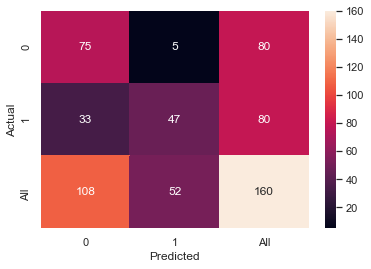

Metrics: 
   Accuracy: 0.762500 
   Precision: 0.903846 
   Recall: 0.587500 
   F1: 0.712121


In [43]:
# print the best parameters
print("Best parameters")
print(grid_result.best_params_)

# The best model
best_random = grid_result.best_estimator_

# Predict Class
random_y_pred = np.concatenate(best_random.predict(x_test))
cnn_embed_metrics, cnn_embed_metrics = getModelInfo(y_test, random_y_pred)


Best parameters
{'vocab_size': 5000, 'num_filters': 64, 'maxlen': 500, 'kernel_size': 7, 'embedding_dim': 100}


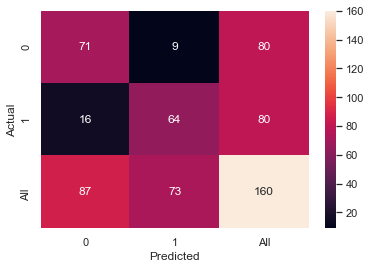

Metrics: 
   Accuracy: 0.843750 
   Precision: 0.876712 
   Recall: 0.800000 
   F1: 0.836601


Algorithm  Multinomial Naive Bayes       CNN  CNN + Glove Embedding
Accuracy                  0.881250  0.843750               0.762500
Precision                 0.917808  0.876712               0.903846
Recall                    0.837500  0.800000               0.587500
F-1                       0.875817  0.836601               0.712121


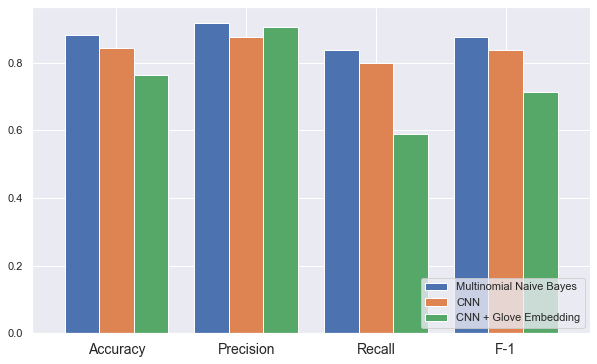

                         Accuracy  Precision  Recall       F-1
Algorithm                                                     
Multinomial Naive Bayes   0.88125   0.917808  0.8375  0.875817
CNN                       0.84375   0.876712  0.8000  0.836601
CNN + Glove Embedding     0.76250   0.903846  0.5875  0.712121


In [57]:
metrics_list.append(cnn_metrics)
metrics_list.append(cnn_embed_metrics)
metrics_list

    
plotMetricsComparison(metrics_list)
save_metrics(metrics_list)

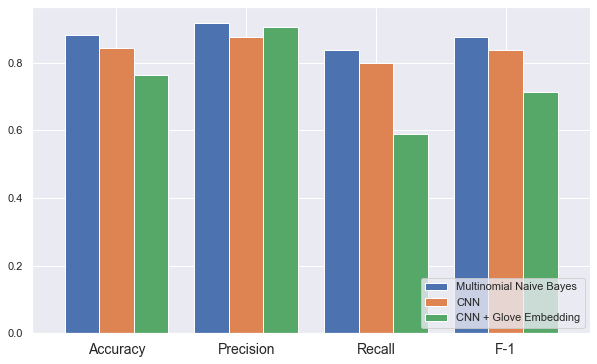
                         Accuracy  Precision  Recall       F-1
Algorithm                                                     
Multinomial Naive Bayes   0.88125   0.917808  0.8375  0.875817
CNN                       0.84375   0.876712  0.8000  0.836601
CNN + Glove Embedding     0.76250   0.903846  0.5875  0.712121

In [3]:
from statsmodels.stats.contingency_tables import mcnemar
def drop_all(cm):
    cm = cm.drop(cm.columns[2], axis=0)
    cm = cm.drop(cm.columns[2], axis=1)
    return cm
print(mnb_random_y_pred)
print(random_y_pred_cnn)

preds = pd.DataFrame({'MNB':mnb_random_y_pred, 'CNN':random_y_pred_cnn})
contingency_table = pd.crosstab(preds['MNB'], preds['CNN'])
print(contingency_table)
result = mcnemar(contingency_table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

NameError: name 'mnb_random_y_pred' is not defined

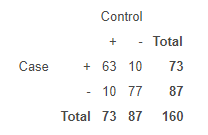